In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import h5py
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from utils import *
from exp_utils import *
from tests import *
from cd_models import *

%config InlineBackend.figure_format = 'retina'

####### Fixing Seed #######
random_seed=42
np.random.seed(random_seed)
###########################

## Setting datasets up

### Loading USPS

In [2]:
with h5py.File('data/usps.h5', 'r') as hf:
        train = hf.get('train')
        test = hf.get('test')
        
        usps_X = np.vstack((train.get('data')[:],test.get('data')[:]))
        usps_X = usps_X.reshape(usps_X.shape[0], 16, 16)
        usps_y = np.hstack((train.get('target')[:],test.get('target')[:]))

usps_X.shape, usps_y.shape

((9298, 16, 16), (9298,))

In [3]:
shuffle = np.random.choice(range(usps_X.shape[0]), size=(usps_X.shape[0],), replace=False)
usps_X=usps_X[shuffle]
usps_y=usps_y[shuffle]

### Loading MNIST

In [4]:
mnist_X=np.load('data/mnist_X.npy')
mnist_y=np.load('data/mnist_y.npy')

In [5]:
shuffle = np.random.choice(range(mnist_X.shape[0]), size=(mnist_X.shape[0],), replace=False)
mnist_X=mnist_X[shuffle]
mnist_y=mnist_y[shuffle]

In [6]:
mnist_X = [cv2.cvtColor(m.astype('uint8'), cv2.COLOR_GRAY2BGR) for m in mnist_X]
mnist_X = np.array([cv2.resize(m, dsize=(16, 16), interpolation=cv2.INTER_CUBIC)[:,:,0].tolist() for m in mnist_X])

### Selecting a subset of MNIST

In [7]:
def at(t,aT,T): 
    return (aT/T)*t

aT=.5 #In the last time point (T), we have aT of USPS points (at increases linearly starting from 0).

In [8]:
m=int(usps_X.shape[0]*((2-aT)/aT))
m

27894

In [9]:
mnist_X=mnist_X[:m]
mnist_y=mnist_y[:m]

mnist_X.shape, mnist_y.shape

((27894, 16, 16), (27894,))

### Normalizing pixels

In [10]:
mnist_X=mnist_X/np.max(mnist_X)
usps_X=usps_X/np.max(usps_X)

### Checking prior dist

In [11]:
for y in np.unique(mnist_y):
    print(y,'{:.3f},{:.3f}'.format(np.mean(mnist_y==y), np.mean(usps_y==y)))

0 0.099,0.167
1 0.110,0.136
2 0.099,0.100
3 0.103,0.089
4 0.096,0.092
5 0.090,0.077
6 0.101,0.090
7 0.105,0.085
8 0.098,0.076
9 0.099,0.088


### Visualizing

In [12]:
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.3   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

***** MNIST *****


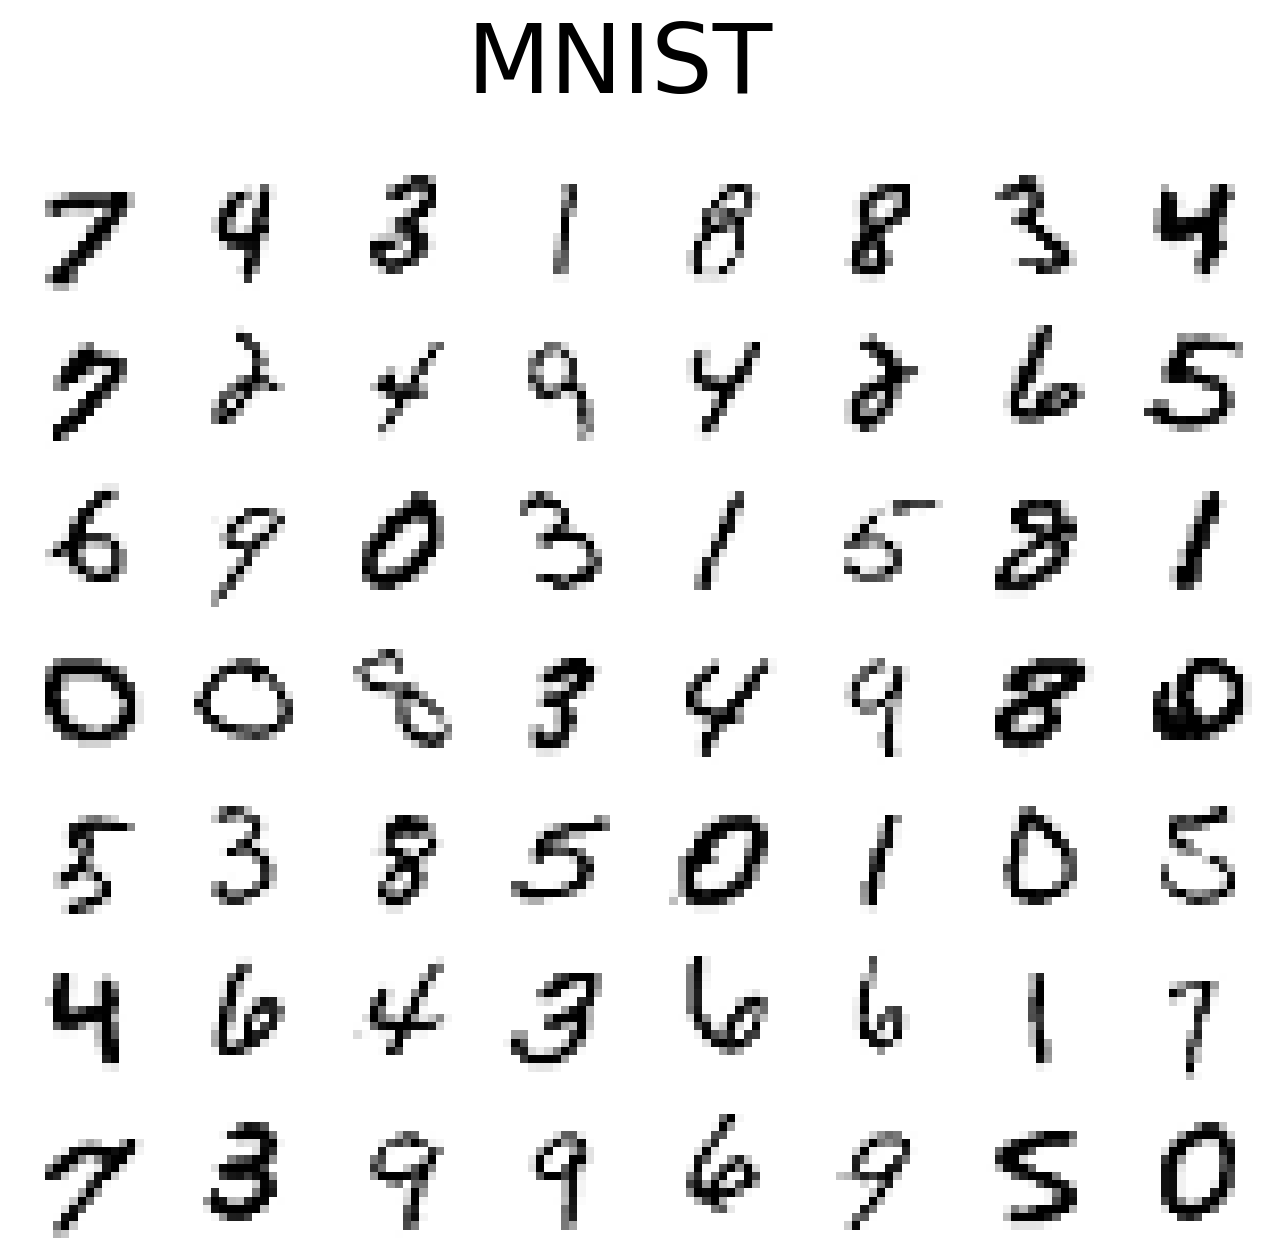


***** USPS *****


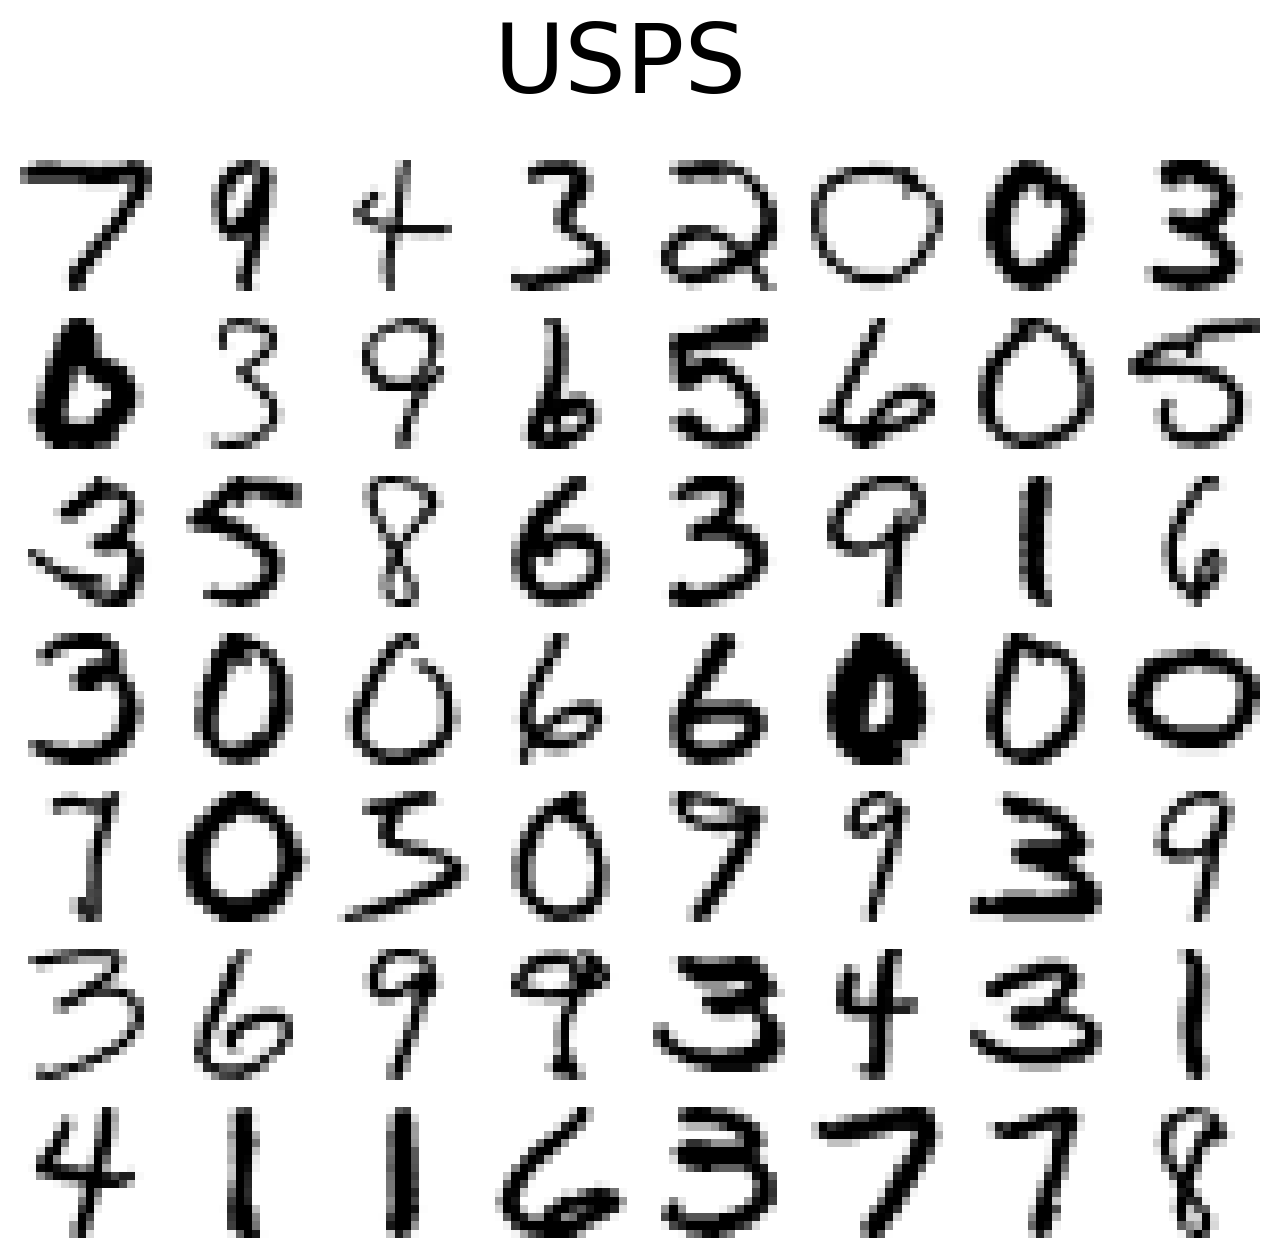

In [13]:
x, y = 8, 7

###
print("***** MNIST *****")
plt.figure(figsize=(x, y))
plt.suptitle('MNIST', fontsize=35)
for i in range(x*y):  
    plt.subplot(y, x, i+1)
    plt.imshow(mnist_X[i],aspect='auto',interpolation='none', cmap='binary')
    plt.axis('off')
plt.savefig('plots/MNIST.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

###
print("\n***** USPS *****")
plt.figure(figsize=(x, y))
plt.suptitle('USPS', fontsize=35)
for i in range(x*y):  
    plt.subplot(y, x, i+1)
    plt.imshow(usps_X[i],aspect='auto',interpolation='none', cmap='binary')
    plt.axis('off')
plt.savefig('plots/USPS.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

### Reshaping data

In [14]:
mnist_X=mnist_X.reshape(mnist_X.shape[0],-1)
usps_X=usps_X.reshape(usps_X.shape[0],-1)

mnist_X.shape, usps_X.shape

((27894, 256), (9298, 256))

### Partitioning data in the T+1 periods 

In [15]:
T=11 #T+1 periods
C=int((mnist_X.shape[0]+usps_X.shape[0])/(T+1))
T,C

(11, 3099)

In [16]:
X=[]
y=[]

mcum=0
ucum=0
theta=[]

for t in range(T+1):
    
    udelta=int(at(t,aT,T)*C)
    mdelta=C-udelta
    
    X.append(np.vstack((mnist_X[mcum:(mcum+mdelta)], usps_X[ucum:(ucum+udelta)])))
    y.append(np.hstack((mnist_y[mcum:(mcum+mdelta)], usps_y[ucum:(ucum+udelta)])))
    theta.append(udelta/(mdelta+udelta))
    
    mcum+=mdelta
    ucum+=udelta
    
    print(X[t].shape)


(3099, 256)
(3099, 256)
(3099, 256)
(3099, 256)
(3099, 256)
(3099, 256)
(3099, 256)
(3099, 256)
(3099, 256)
(3099, 256)
(3099, 256)
(3096, 256)


## Detecting dataset shift

In [17]:
_,d=X[0].shape
d

256

In [18]:
pvals=[]
kls=[]
covshift_models=[]
task='class'
test=.1
B=250

for t in tqdm(range(T+1)):

    ### Setting-up data
    Xs_train, Xs_test, ys_train, ys_test, Zs_train, Zs_test, \
    Xt_train, Xt_test, yt_train, yt_test, Zt_train, Zt_test = prep_data(X[0], y[0], X[t], y[t], test=test, task=task, random_state=t)
    
    ### Training models
    totshift_model = KL(boost=True)
    totshift_model.fit(Zs_train, Zt_train)
    covshift_models.append(KL(boost=True))
    covshift_models[-1].fit(Xs_train, Xt_train)

    cd_model = cde_class(boost=True)
    cd_model.fit(pd.concat([Xs_train, Xt_train], axis=0), 
                 pd.concat([ys_train, yt_train], axis=0))
    
    ### Getting test statistics and p-vals
    out = ShiftDiagnostics(Xs_test, ys_test, Xt_test, yt_test,
                           totshift_model=totshift_model, covshift_model=covshift_models[-1], labshift_model=None,
                           cd_model=cd_model, task=task, B=B, verbose=False)

    ### Output
    pvals.append([theta[t], out['lab']['pval'], out['cov']['pval'], out['conc1']['pval'], out['conc2']['pval'], out['tot']['pval']])
    kls.append([theta[t], out['lab']['kl'], out['cov']['kl'], out['conc1']['kl'], out['conc2']['kl'], out['tot']['kl']])


100%|██████████████████████████████████████████| 12/12 [20:01<00:00, 100.15s/it]


In [19]:
kls=np.array(kls)
pvals=np.array(pvals)

In [20]:
kls.shape

(12, 6)

Classification

In [21]:
loss=[]
std_error=[]

for t in tqdm(range(T+1)):

    ### Setting-up data
    Xs_train, Xs_test, ys_train, ys_test, _, _, \
    Xt_train, Xt_test, yt_train, yt_test, _, _ = prep_data(X[0], y[0], X[t], y[t], test=test, task=task, random_state=t)
    ys_train, ys_test, yt_train, yt_test = get_classes(ys_train), get_classes(ys_test), get_classes(yt_train), get_classes(yt_test)
    
    ### Predictions
    #naive
    model = LogisticRegression(solver='liblinear', random_state=random_seed).fit(Xs_train, ys_train.squeeze())
    y_hat = model.predict_proba(Xt_test)
    loss.append([log_loss(yt_test, y_hat),None])
    n=yt_test.shape[0]
    std_error.append([np.std(-np.log([y_hat[i,yt_test[i]] for i in range(n)]))/np.sqrt(n),None])
    
    #weighted
    w=covshift_models[t].predict_w(Xs_train)
    model = LogisticRegression(solver='liblinear', random_state=random_seed).fit(Xs_train, ys_train.squeeze(), sample_weight=w)
    y_hat = model.predict_proba(Xt_test)
    loss[-1][1]=log_loss(yt_test,y_hat)
    n=yt_test.shape[0]
    std_error[-1][1]=np.std(-np.log([y_hat[i,yt_test[i]] for i in range(n)]))/np.sqrt(n)
    

100%|███████████████████████████████████████████| 12/12 [00:08<00:00,  1.41it/s]


In [22]:
loss=np.array(loss)
std_error=np.array(std_error)

Plots

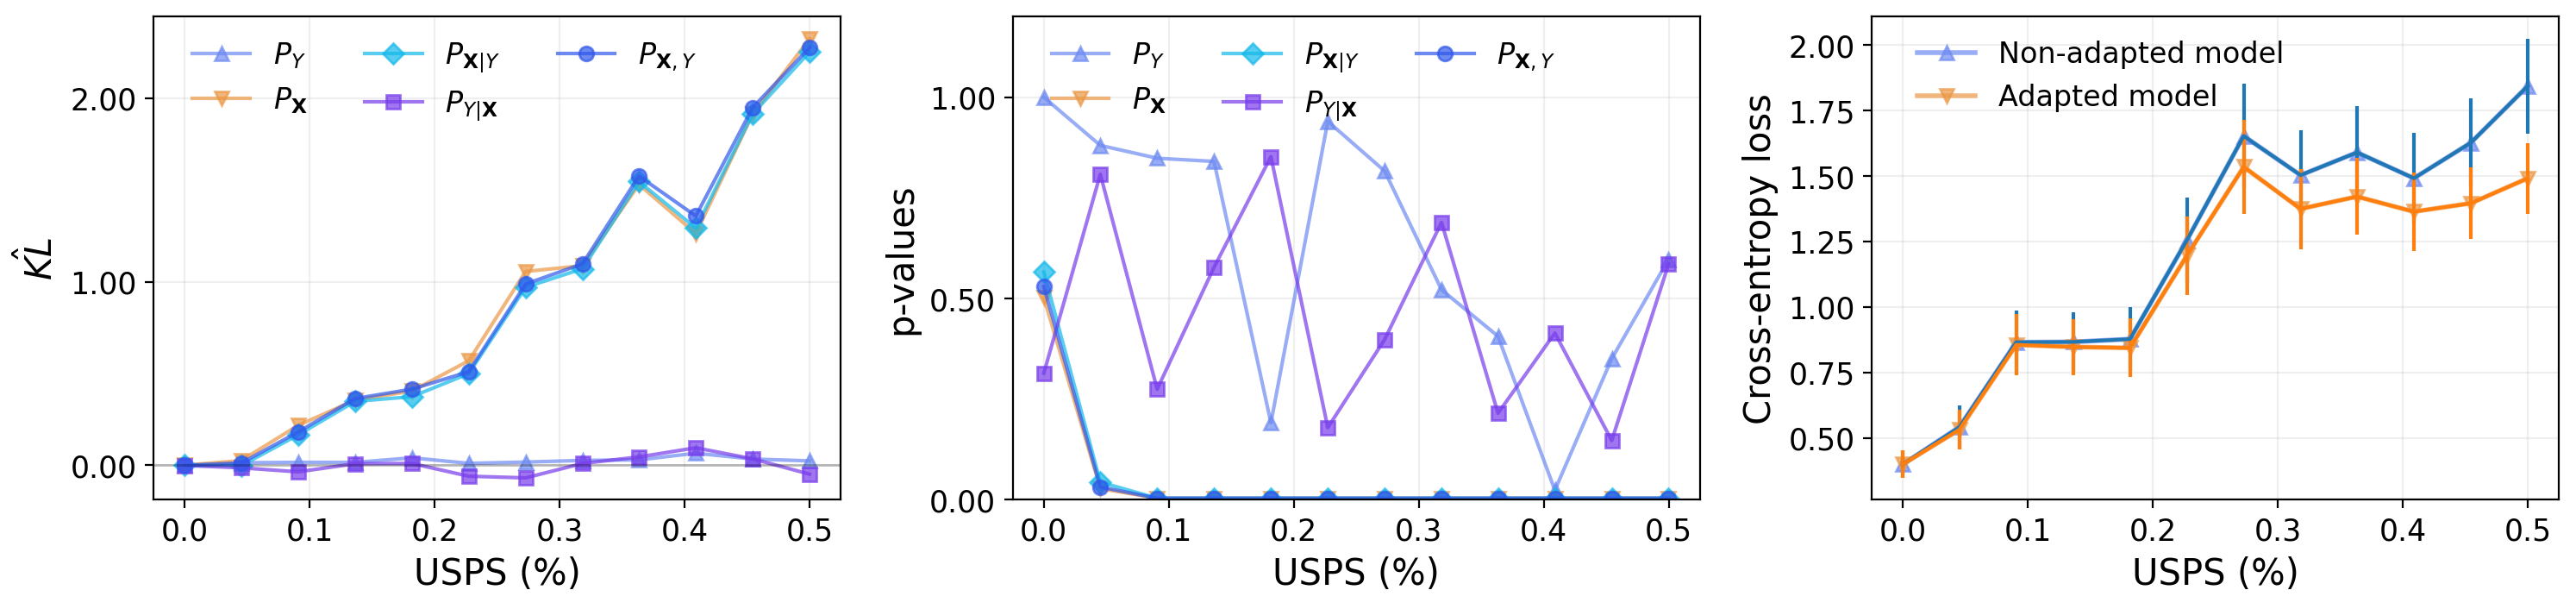

In [38]:
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.25   # the amount of width reserved for blank space between subplots
hspace = 0.35   # the amount of height reserved for white space between subplots

plt.figure(figsize=(18,3.5))
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

###SHIFTS
plt.subplot(1, 3, 1)
exp_plots(theta, kls, xlab="USPS (%)", ylab="$\hat{KL}$", grid='both')
plt.tick_params(labelsize=12.5)

plt.subplot(1, 3, 2)
exp_plots(theta, pvals, xlab="USPS (%)", ylab="p-values", grid='both')
plt.tick_params(labelsize=12.5)
plt.ylim(0,1.2)

###PREDICTIONS
plt.subplot(1, 3, 3)
names=['Non-adapted model','Adapted model']
colors=['#2F58EB', '#773BEB', '#12B8EB', '#EB9846', '#6D8AF1','#808080']
grid='both'
ylab='Cross-entropy loss'
plt.plot(theta,loss[:,0], color=colors[4], marker="^", lw=2, label=names[0], alpha=.7, markersize=6)
plt.errorbar(theta,loss[:,0], yerr=std_error[:,0])
plt.plot(theta,loss[:,1], color=colors[3], marker="v", lw=2, label=names[1], alpha=.7, markersize=6)
plt.errorbar(theta,loss[:,1], yerr=std_error[:,1])
plt.legend(bbox_to_anchor=(.05, .975), loc='upper left', ncol = 1, prop={'size': 12}, borderaxespad=.0, frameon=False)     
plt.grid(alpha=.2, axis=grid)
plt.ylabel(ylab, size=15)
plt.xlabel("USPS (%)", size=15)
plt.tick_params(labelsize=12.5)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%1.2f'))
plt.savefig('plots/digits.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()